### Notebook 6: LSTM Model for Ethereum (ETH)

# LSTM Model for Predicting Ethereum Prices (ETH)

## Overview
This notebook presents the implementation and evaluation of the LSTM (Long Short-Term Memory) model for predicting Ethereum (ETH) prices. The LSTM model is particularly effective for time series analysis due to its ability to learn long-term dependencies.

##

 Objectives
- **Feature Engineering:** Develop relevant features from raw financial and economic data for ETH.
- **Model Implementation:** Implement the LSTM model to predict ETH prices.
- **Model Evaluation:** Evaluate the performance of the LSTM model using MSE, RMSE, MAE, and R2 scores.
- **Insights and Interpretation:** Provide insights into the model's performance and the impact of various features on ETH prices.

## Data Sources
- **Financial Data:** Historical prices for Ethereum from Yahoo Finance.
- **Economic Data:** Key economic indicators from the Federal Reserve Economic Data (FRED), including Real Disposable Income, Fed Funds Rate, and more.

## Methodology
1. **Data Collection:** Download and preprocess ETH financial and economic data.
2. **Feature Engineering:** Create technical indicators and integrate economic indicators relevant to ETH.
3. **Model Development:** Build and train the LSTM model for ETH prices.
4. **Model Evaluation:** Assess the model's performance using key metrics.
5. **Insights and Interpretation:** Analyze the results to understand the model's predictions and market behavior for ETH.

## Evaluation Metrics
- **Mean Squared Error (MSE)**
- **Root Mean Squared Error (RMSE)**
- **Mean Absolute Error (MAE)**
- **R2 Score**

## Key Findings
- **Training and Test Metrics:** Evaluate the model's performance on training and test data.
- **Feature Impact:** Understand the influence of various features on the predictions.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Fitting 3 folds for each of 2 candidates, totalling 6 fits


2024-06-27 18:55:47.060416: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 18:55:47.784557: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14628 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:d8:00.0, compute capability: 7.0
2024-06-27 18:55:51.345712: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


[CV] END batch_size=16, dropout_rate=0.2, epochs=10, units=100; total time=   6.7s
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, units=100; total time=   5.0s
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, units=100; total time=   6.1s
[CV] END batch_size=16, dropout_rate=0.3, epochs=10, units=100; total time=   4.5s
[CV] END batch_size=16, dropout_rate=0.3, epochs=10, units=100; total time=   4.9s
[CV] END batch_size=16, dropout_rate=0.3, epochs=10, units=100; total time=   6.1s
ETH-USD - Best Parameters: {'units': 100, 'epochs': 10, 'dropout_rate': 0.2, 'batch_size': 16}
ETH-USD - Best R2 Score: 0.755952659440724
ETH-USD - Training MSE: 0.0001
ETH-USD - Training MSE Variance: 0.0000
ETH-USD - Test MSE: 0.0002
ETH-USD - Test MSE Variance: 0.0000
ETH-USD - Training RMSE: 0.0091
ETH-USD - Training RMSE Variance: 0.0000
ETH-USD - Test RMSE: 0.0117
ETH-USD - Test RMSE Variance: 0.0000
ETH-USD - Training MAE: 0.0064
ETH-USD - Training MAE Variance: 0.0000
ETH-USD - Test MAE: 0

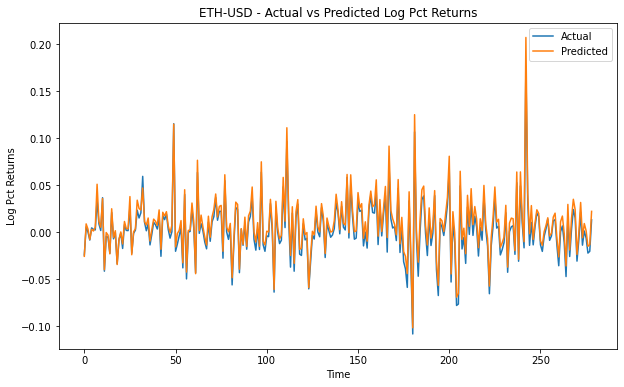

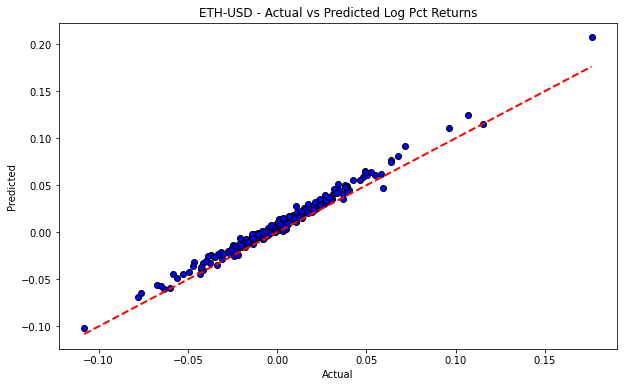

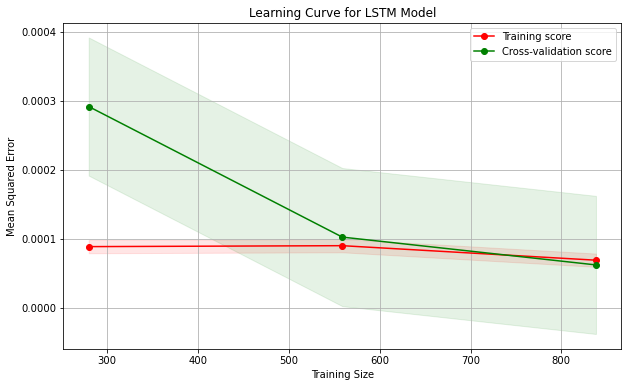

Future predictions saved to eth_usd_future_predictions.csv


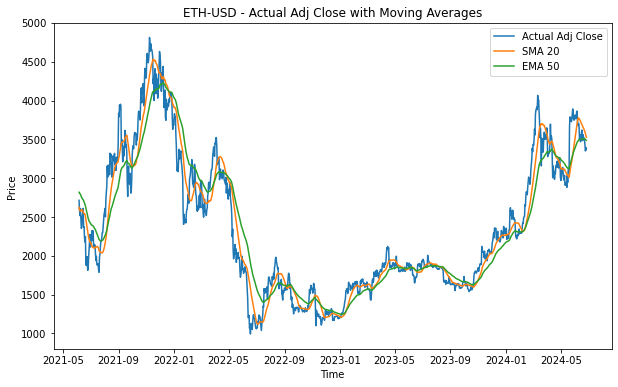

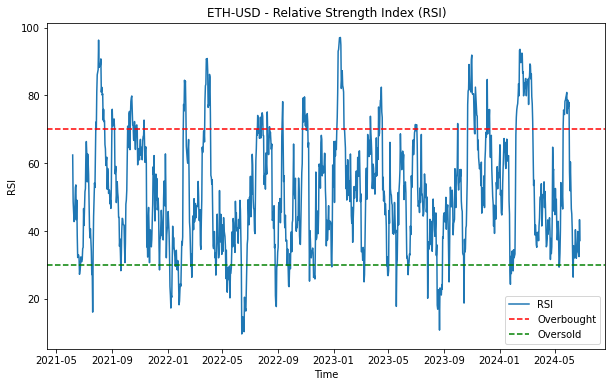

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional
from keras.wrappers.scikit_learn import KerasRegressor
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the start and end dates for data download
end_date = datetime.now()
start_date = datetime(2021, 4, 14)

def download_data(ticker, start_date, end_date):
    data = yf.download(tickers=ticker, start=start_date, end=end_date)
    df = pd.DataFrame(data)
    df.reset_index(inplace=True)
    df.set_index('Date', inplace=True)
    return df

def add_features(df, df_gold, df_usindex):
    df['Gold_Adj_Close'] = df_gold['Adj Close']
    df['USIndex_Adj_Close'] = df_usindex['Adj Close']
    df.ffill(inplace=True)

    # Calculate additional features
    df['Open_Close_Diff'] = df['Open'] - df['Adj Close']
    df['High_Low_Diff'] = df['High'] - df['Low']
    df['Pct_Returns'] = df['Adj Close'].pct_change()
    df['Log_Pct_Returns'] = np.log(1 + df['Pct_Returns'])
    df.dropna(inplace=True)

    # Moving Averages
    df['SMA_5'] = df['Adj Close'].rolling(window=5).mean()
    df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
    df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Adj Close'].rolling(window=50).mean()
    df['EMA_50'] = df['Adj Close'].ewm(span=50, adjust=False).mean()

    # Relative Strength Index (RSI)
    window_length = 14
    delta = df['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    df['MACD'] = df['Adj Close'].ewm(span=12, adjust=False).mean() - df['Adj Close'].ewm(span=26, adjust=False).mean()
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

    # Bollinger Bands
    df['BB_Upper'] = df['SMA_20'] + 2 * df['Adj Close'].rolling(window=20).std()
    df['BB_Lower'] = df['SMA_20'] - 2 * df['Adj Close'].rolling(window=20).std()

    # Stochastic Oscillator
    df['14-high'] = df['High'].rolling(14).max()
    df['14-low'] = df['Low'].rolling(14).min()
    df['%K'] = (df['Adj Close'] - df['14-low']) * 100 / (df['14-high'] - df['14-low'])
    df['%D'] = df['%K'].rolling(3).mean()

    # Average True Range (ATR)
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = np.abs(df['High'] - df['Adj Close'].shift(1))
    df['L-PC'] = np.abs(df['Low'] - df['Adj Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(14).mean()

    return df

def shift_columns(df, columns_to_shift, num_lags):
    for column in columns_to_shift:
        for lag in range(1, num_lags + 1):
            df[f'{column}_{lag}'] = df[column].shift(lag)
    df['Pct_Returns_1'] = df['Pct_Returns'].shift(1)
    df['Log_Pct_Returns_1'] = df['Log_Pct_Returns'].shift(1)
    df.dropna(inplace=True)
    return df

def fetch_and_preprocess_economic_data(start_date, end_date):
    economic_indicators = {
        'T5YIE': 'Inflation',
        'FEDFUNDS': 'FedFunds',
        'GDPC1': 'GDP',
        'UNRATE': 'Unemployment',
        'UMCSENT': 'ConsumerSentiment',
        'CPILFESL': 'CoreCPI',
        'PPIACO': 'CommodityPrices',
        'WM2NS': 'M2MoneySupply'
    }
    
    dfs_economic = {}
    
    for code, name in economic_indicators.items():
        df = pdr.get_data_fred(code, start=start_date, end=end_date)
        df = df.resample('D').ffill().dropna()
        df.columns = [name]
        dfs_economic[name] = df
    
    return dfs_economic

def merge_economic_data(df, dfs_economic):
    for econ_name, econ_df in dfs_economic.items():
        df[econ_name] = econ_df[econ_name]
    return df

def evaluate_model(y_train, y_test, y_train_pred, y_test_pred):
    metrics = {}
    metrics['train_mse'] = mean_squared_error(y_train, y_train_pred)
    metrics['test_mse'] = mean_squared_error(y_test, y_test_pred)
    metrics['train_rmse'] = np.sqrt(metrics['train_mse'])
    metrics['test_rmse'] = np.sqrt(metrics['test_mse'])
    metrics['train_mae'] = mean_absolute_error(y_train, y_train_pred)
    metrics['test_mae'] = mean_absolute_error(y_test, y_test_pred)
    metrics['train_r2'] = r2_score(y_train, y_train_pred)
    metrics['test_r2'] = r2_score(y_test, y_test_pred)
    return metrics

def plot_results(y_test, y_test_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_test_pred, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Log Pct Returns')
    plt.title('ETH-USD - Actual vs Predicted Log Pct Returns')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('ETH-USD - Actual vs Predicted Log Pct Returns')
    plt.show()

def future_prediction_lstm(model, future_steps, X_scaled):
    """
    Generate future predictions using the LSTM model.

    :param model: The trained LSTM model.
    :param future_steps: The number of future steps to predict.
    :param X_scaled: The scaled input data.
    :return: A DataFrame with future dates and predicted log returns.
    """
    predictions = []
    current_batch = X_scaled[-1].reshape(1, 1, X_scaled.shape[2])
    
    for _ in range(future_steps):
        pred = model.predict(current_batch)[0]
        predictions.append(pred)
        # Append the new prediction to the current batch and keep the batch size fixed
        current_batch = np.append(current_batch[:, :, 1:], [[pred]], axis=2)
        
    future_dates = pd.date_range(start=df_eth.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='B')
    df_future_predictions = pd.DataFrame({'Date': future_dates, 'Predicted_Log_Return': predictions})
    df_future_predictions.set_index('Date', inplace=True)
    return df_future_predictions

def plot_learning_curve(train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std):
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.xlabel('Training Size')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve for LSTM Model')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Download data
df_eth = download_data('ETH-USD', start_date, end_date)
df_gold = download_data('GC=F', start_date, end_date)
df_usindex = download_data('DX-Y.NYB', start_date, end_date)

# Add features
df_eth = add_features(df_eth, df_gold, df_usindex)

# Shift columns to create lagged features
columns_to_shift = [
    'Open', 'High', 'Adj Close', 'Low', 'Volume',
    'Open_Close_Diff', 'High_Low_Diff',
    'Gold_Adj_Close', 'USIndex_Adj_Close',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_50',
    'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Lower',
    '%K', '%D', 'ATR'
]
num_lags = 3
df_eth = shift_columns(df_eth, columns_to_shift, num_lags)

# Fetch and merge economic data
dfs_economic = fetch_and_preprocess_economic_data(start_date, end_date)
df_eth = merge_economic_data(df_eth, dfs_economic)

# Define features and target variable
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','Adj Close_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'USIndex_Adj_Close_1',
            'Open_2', 'High_2', 'Low_2','Adj Close_2',
            'Open_Close_Diff_2','USIndex_Adj_Close_2',
            'Open_3',  'Low_3',
            'USIndex_Adj_Close_3',
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1',
            'EMA_50_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1',  '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_50_2',
            'MACD_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2'
           ]
X = df_eth[features].dropna()
y = df_eth['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape X_scaled for LSTM input
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)  # Reduced for quicker testing

# Function to create the LSTM model
def create_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=units, input_shape=(X_scaled.shape[1], X_scaled.shape[2]))))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create the model for RandomizedSearchCV
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters grid
param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'epochs': [5, 10, 20],  # Adjusted for more tuning
    'batch_size': [16, 32]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=2, cv=tscv, scoring='r2', n_jobs=-1, verbose=2)

# Fit the RandomizedSearchCV
random_result = random_search.fit(X_scaled, y)

# Print the best parameters and best score
print(f"ETH-USD - Best Parameters: {random_result.best_params_}")
print(f"ETH-USD - Best R2 Score: {random_result.best_score_}")

# Get the best model
best_model = random_result.best_estimator_.model

# Initialize lists to store metrics
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []

# Perform cross-validation with the best model
train_sizes, train_scores, test_scores = [], [], []

for train_index, test_index in tscv.split(X_scaled):
    train_sizes.append(len(train_index))
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the best model
    best_model.fit(X_train, y_train, epochs=random_result.best_params_['epochs'], batch_size=random_result.best_params_['batch_size'], verbose=0)

    # Predict on the test set
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Calculate performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Append metrics to lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

    train_scores.append(train_mse)
    test_scores.append(test_mse)

# Function to calculate mean and variance
def calculate_mean_and_variance(scores):
    mean_score = np.mean(scores)
    variance_score = np.var(scores)
    return mean_score, variance_score

# Calculate mean and variance of the scores
mean_train_mse, var_train_mse = calculate_mean_and_variance(train_mse_scores)
mean_test_mse, var_test_mse = calculate_mean_and_variance(test_mse_scores)
mean_train_rmse, var_train_rmse = calculate_mean_and_variance(train_rmse_scores)
mean_test_rmse, var_test_rmse = calculate_mean_and_variance(test_rmse_scores)
mean_train_mae, var_train_mae = calculate_mean_and_variance(train_mae_scores)
mean_test_mae, var_test_mae = calculate_mean_and_variance(test_mae_scores)
mean_train_r2, var_train_r2 = calculate_mean_and_variance(train_r2_scores)
mean_test_r2, var_test_r2 = calculate_mean_and_variance(test_r2_scores)

# Print Results
print("ETH-USD - Training MSE: {:.4f}".format(mean_train_mse))
print("ETH-USD - Training MSE Variance: {:.4f}".format(var_train_mse))
print("ETH-USD - Test MSE: {:.4f}".format(mean_test_mse))
print("ETH-USD - Test MSE Variance: {:.4f}".format(var_test_mse))
print("ETH-USD - Training RMSE: {:.4f}".format(mean_train_rmse))
print("ETH-USD - Training RMSE Variance: {:.4f}".format(var_train_rmse))
print("ETH-USD - Test RMSE: {:.4f}".format(mean_test_rmse))
print("ETH-USD - Test RMSE Variance: {:.4f}".format(var_test_rmse))
print("ETH-USD - Training MAE: {:.4f}".format(mean_train_mae))
print("ETH-USD - Training MAE Variance: {:.4f}".format(var_train_mae))
print("ETH-USD - Test MAE: {:.4f}".format(mean_test_mae))
print("ETH-USD - Test MAE Variance: {:.4f}".format(var_test_mae))
print("ETH-USD - Training R2: {:.4f}".format(mean_train_r2))
print("ETH-USD - Training R2 Variance: {:.4f}".format(var_train_r2))
print("ETH-USD - Test R2: {:.4f}".format(mean_test_r2))
print("ETH-USD - Test R2 Variance: {:.4f}".format(var_test_r2))

# Visualize model performance
plot_results(y_test, y_test_pred)

# Learning curve
plot_learning_curve(np.array(train_sizes), np.array(train_scores), np.std(train_scores), np.array(test_scores), np.std(test_scores))

# Future prediction for 365 days
future_steps = 365
df_future_predictions = future_prediction_lstm(best_model, future_steps, X_scaled)

# Save results to CSV
df_future_predictions.to_csv('eth_usd_future_predictions.csv')
print("Future predictions saved to eth_usd_future_predictions.csv")

# Additional Plots
plt.figure(figsize=(10, 6))
plt.plot(df_eth['Adj Close'], label='Actual Adj Close')
plt.plot(df_eth['SMA_20'], label='SMA 20')
plt.plot(df_eth['EMA_50'], label='EMA 50')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('ETH-USD - Actual Adj Close with Moving Averages')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_eth['RSI'], label='RSI')
plt.axhline(y=70, color='r', linestyle='--', label='Overbought')
plt.axhline(y=30, color='g', linestyle='--', label='Oversold')
plt.xlabel('Time')
plt.ylabel('RSI')
plt.title('ETH-USD - Relative Strength Index (RSI)')
plt.legend()
plt.show()


In [2]:
# Function to calculate mean and variance
def calculate_mean_and_variance(scores):
    mean_score = np.mean(scores)
    variance_score = np.var(scores)
    return mean_score, variance_score

# Calculate mean and variance of the scores
mean_train_mse, var_train_mse = calculate_mean_and_variance(train_mse_scores)
mean_test_mse, var_test_mse = calculate_mean_and_variance(test_mse_scores)
mean_train_rmse, var_train_rmse = calculate_mean_and_variance(train_rmse_scores)
mean_test_rmse, var_test_rmse = calculate_mean_and_variance(test_rmse_scores)
mean_train_mae, var_train_mae = calculate_mean_and_variance(train_mae_scores)
mean_test_mae, var_test_mae = calculate_mean_and_variance(test_mae_scores)
mean_train_r2, var_train_r2 = calculate_mean_and_variance(train_r2_scores)
mean_test_r2, var_test_r2 = calculate_mean_and_variance(test_r2_scores)

# Print Results
print("ETH-USD - Training MSE: {:.8f}".format(mean_train_mse))
print("ETH-USD - Training MSE Variance: {:.10f}".format(var_train_mse))
print("ETH-USD - Test MSE: {:.8f}".format(mean_test_mse))
print("ETH-USD - Test MSE Variance: {:.8f}".format(var_test_mse))
print("ETH-USD - Training RMSE: {:.8f}".format(mean_train_rmse))
print("ETH-USD - Training RMSE Variance: {:.8f}".format(var_train_rmse))
print("ETH-USD - Test RMSE: {:.8f}".format(mean_test_rmse))
print("ETH-USD - Test RMSE Variance: {:.8f}".format(var_test_rmse))
print("ETH-USD - Training MAE: {:.8f}".format(mean_train_mae))
print("ETH-USD - Training MAE Variance: {:.8f}".format(var_train_mae))
print("ETH-USD - Test MAE: {:.8f}".format(mean_test_mae))
print("ETH-USD - Test MAE Variance: {:.8f}".format(var_test_mae))
print("ETH-USD - Training R2: {:.8f}".format(mean_train_r2))
print("ETH-USD - Training R2 Variance: {:.8f}".format(var_train_r2))
print("ETH-USD - Test R2: {:.8f}".format(mean_test_r2))
print("ETH-USD - Test R2 Variance: {:.8f}".format(var_test_r2))

ETH-USD - Training MSE: 0.00008259
ETH-USD - Training MSE Variance: 0.0000000001
ETH-USD - Test MSE: 0.00015204
ETH-USD - Test MSE Variance: 0.00000001
ETH-USD - Training RMSE: 0.00907196
ETH-USD - Training RMSE Variance: 0.00000029
ETH-USD - Test RMSE: 0.01169387
ETH-USD - Test RMSE Variance: 0.00001530
ETH-USD - Training MAE: 0.00641794
ETH-USD - Training MAE Variance: 0.00000014
ETH-USD - Test MAE: 0.00820459
ETH-USD - Test MAE Variance: 0.00000247
ETH-USD - Training R2: 0.95585171
ETH-USD - Training R2 Variance: 0.00000066
ETH-USD - Test R2: 0.87361022
ETH-USD - Test R2 Variance: 0.00199777
